In [14]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [2]:
inputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "inputs")

# load fred description and data
des_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_description.csv'), sep=";")

fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_transf.csv'))
fred_df["date"] = pd.to_datetime(fred_df["date"])
fred_df.set_index("date", inplace=True)

raw_fred_df = pd.read_csv(os.path.join(inputs_path, 'fredmd_raw.csv'))
raw_fred_df["date"] = pd.to_datetime(raw_fred_df["date"])
raw_fred_df.set_index("date", inplace=True)

In [3]:
# chek for missing values
fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI             1960-01-01
T5YFFM          1960-01-01
T1YFFM          1960-01-01
TB6SMFFM        1960-01-01
TB3SMFFM        1960-01-01
                   ...    
VIXCLSx         1962-07-01
ANDENOx         1968-03-01
TWEXAFEGSMTHx   1973-02-01
UMCSENTx        1978-02-01
ACOGNO          1992-03-01
Length: 127, dtype: datetime64[ns]

In [4]:
delete_groups = ["Interest and Exchange Rates", "Stock Market"]
delete_series = ["ACOGNO", "UMCSENTx", "TWEXAFEGSMTHx"]

# delete groups
macro_fred = []
for colname in fred_df.columns:

    if colname not in des_fred_df["fred"].values:
        continue

    group = des_fred_df[des_fred_df["fred"] == colname]["group"].values[0]

    if (group not in delete_groups) and (colname not in delete_series):
        macro_fred.append(fred_df[colname])
macro_fred_df = pd.concat(macro_fred, axis=1)

In [5]:
# chek for missing values
macro_fred_df.apply(lambda x: x.dropna().first_valid_index()).sort_values()

RPI               1960-01-01
CONSPI            1960-01-01
NONREVSL          1960-01-01
REALLN            1960-01-01
BUSLOANS          1960-01-01
                     ...    
UEMP15OV          1960-01-01
UEMP5TO14         1960-01-01
MANEMP            1960-01-01
DSERRG3M086SBEA   1960-01-01
ANDENOx           1968-03-01
Length: 96, dtype: datetime64[ns]

## 1) Easy days - Kmeans vs GMM using Euclidean distance

In [19]:
# select data
X = macro_fred_df.dropna()

# compute euclidean distance
X_euclidean = euclidean_distances(X)

X_euclidean_df = pd.DataFrame(X_euclidean, index=X.index, columns=X.index)

<Axes: title={'center': 'Sanity check Euclidean distance'}>

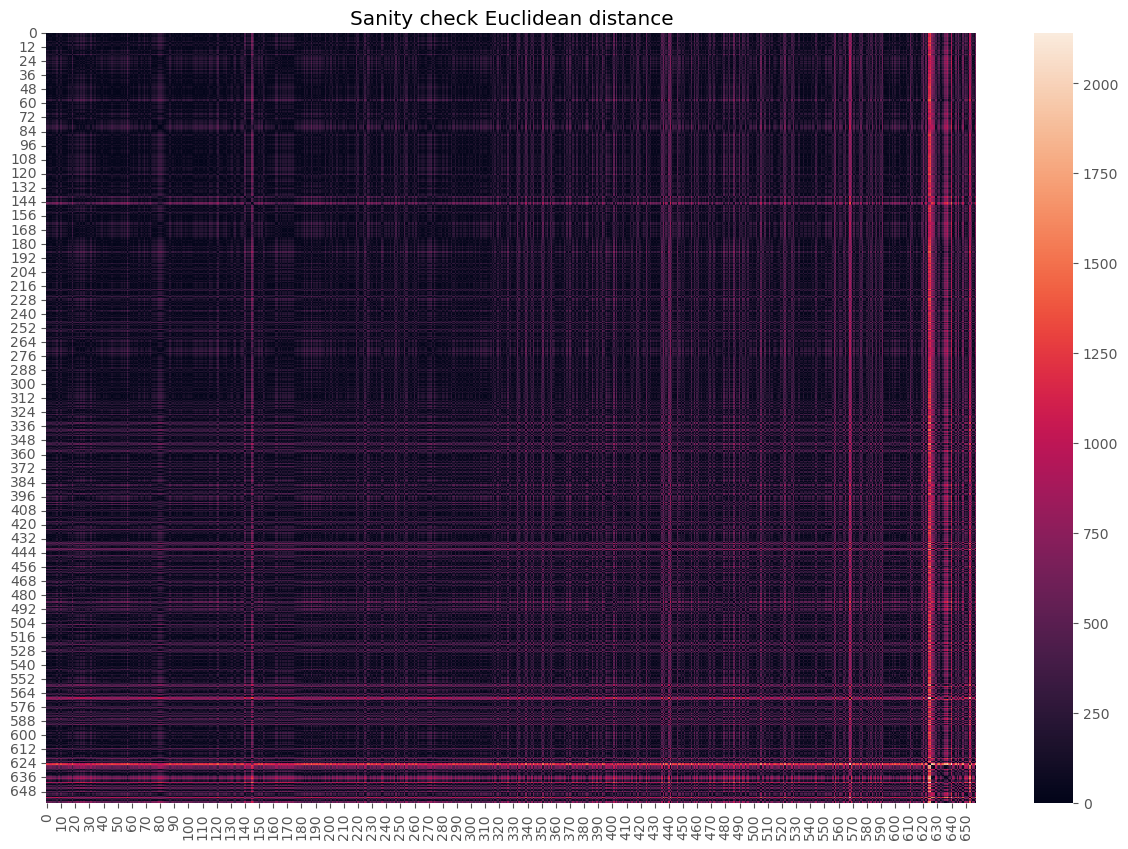

In [13]:
plt.figure(figsize=(15, 10))
plt.title("Sanity check Euclidean distance")
sns.heatmap(X_euclidean)

In [16]:
# parameters
k = 2
seed = 2294

# compute kmeans
kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_euclidean)

# compute gmm
gmm = GaussianMixture(n_components=k, random_state=seed).fit(X_euclidean)

# computer clusters from both methods
kmeans_clusters = kmeans.labels_
gmm_clusters = gmm.predict(X_euclidean)

In [36]:
# create time series of clusters for kmeans
X_plot = X.copy()
X_plot.loc[:, "cluster"] = kmeans.labels_

melt_X = X_plot[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)
kmeans_pivot_X = pivot_X.copy()
kmeans_pivot_X.columns = kmeans_pivot_X.columns.droplevel()

# create time series of clusters for gmm
X_plot = X.copy()
X_plot.loc[:, "cluster"] = gmm_clusters

melt_X = X_plot[["cluster"]].reset_index().melt("date").drop(["variable"], axis=1)
melt_X.rename(columns={"value": "cluster"}, inplace=True)
melt_X.loc[:, "value"] = 1
melt_X.loc[:, "value"] = melt_X["value"] * melt_X["cluster"]
pivot_X = melt_X.pivot_table(index=["date"], columns=["cluster"], values=["value"])
pivot_X.index = pd.to_datetime(pivot_X.index)
gmm_pivot_X = pivot_X.copy()
gmm_pivot_X.columns = gmm_pivot_X.columns.droplevel()

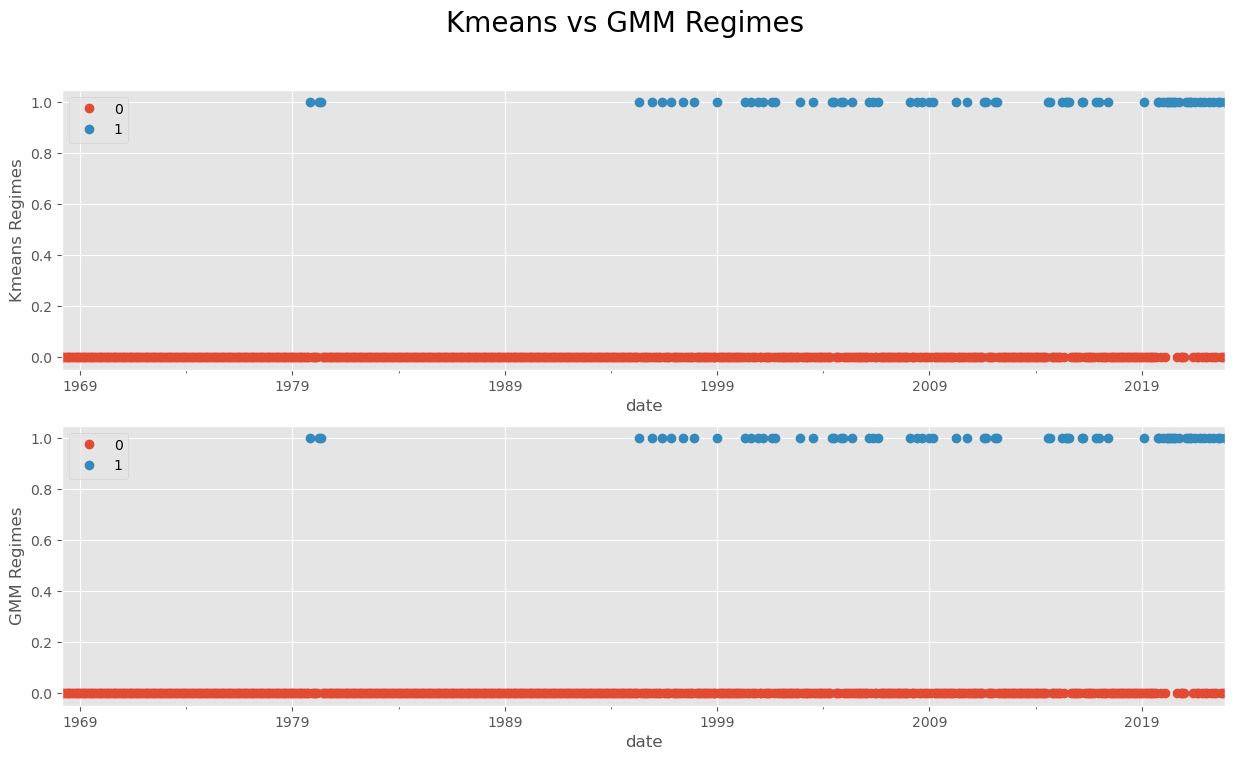

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# add title
fig.suptitle("Kmeans vs GMM Regimes", fontsize=20)
kmeans_pivot_X[[v for v in range(k)]].plot(ax=axs[0], marker="o", linestyle="")
axs[0].set_xlabel("date")
axs[0].set_ylabel("Kmeans Regimes")
axs[0].legend()

gmm_pivot_X[[v for v in range(k)]].plot(ax=axs[1], marker="o", linestyle="")
axs[1].set_xlabel("date")
axs[1].set_ylabel("GMM Regimes")
axs[1].legend()

## 1) Hard days - Kmeans vs GMM using Euclidean distance